# Ventilation Power Analysis

https://gist.github.com/csaid/84819e16bae145b0139b57521f852a11

At steady state, the concentration in a room is Ef/VR where E is the rate of exhaled virus, f is filtration, V is the volume of the room, and R is the virus removal rate (i.e. the sum of ventilation rate, viral decay, aerosol deposition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ttest_ind, ttest_rel, wilcoxon
from scipy.optimize import minimize
from bisect import bisect
import logging
from collections import defaultdict
from typing import List, Set, Dict

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'
lightgray='#cccccc'
yellow='#f1d321'
orange='#f58032'
green='#12ed9d'
red='#ed1262'

In [4]:
def get_hazard(cpml,  multiplier=1):
    """
    - cpml is an array of viral counts (in cp/mL)
    - multiplier is a multiplier on transmission and can be affected by ventilation, filtration, duration, etc.
        Assumes steady state dynamics. 
    
    returns a list of the corresponding inhaled quanta for someone in the same room as the donor
    """
    return 1e-7 * multiplier * cpml

def get_flattened_cpml(cpml, recipient_counts):
    """
    - cpml is an array of viral counts (in cp/mL) for the donors, the length of the number of donors
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.

    returns a list of donor viral counts for each recipient, the length the number of recipients. 
       Assumes each recipient has one donor.
    """
    flattened_cpml = []
    for donor_cpml, cnt in zip(cpml, recipient_counts):
        for i in range(cnt):
            flattened_cpml.append(donor_cpml)
    return flattened_cpml

def infects_to_counts(infections: np.array, recipient_counts: np.array) -> List[int]:
    """
    - infections is an array of 1s and 0s, the length of the number of recipients
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.

    returns a list of the number of infections per donor, the length the number of donors
    """
    did_infects_idx = 0
    infection_counts = []
    for group_idx, group_len in enumerate(recipient_counts):
        infection_count = 0
        for i in range(group_len):
            infection_count += infections[did_infects_idx]
            
            did_infects_idx += 1
        infection_counts.append(infection_count)
    return infection_counts
    
def simulate_experiment(flattened_cpml, recipient_counts, suscept_sd=1, multiplier=1):
    """
    - flattened_cpml is a list of donor viral counts for each recipient, the length the number of recipients. 
    - recipient_counts is a list of recipient counts per donor, the length the number of donors.
    - suscept_sd is the standard deviation of recipient suceptibilities, in log space
    - multiplier is a multiplier on transmission and can be affected by ventilation, filtration, duration, etc.
        Assumes steady state dynamics

    returns a list of infection counts for each donor (length the number of donors) as well as a binary list of
        infection (length the number of recipients)
    """
    
    n = len(flattened_cpml)
    infections = []
    susceptibilities = 10**(suscept_sd * np.random.randn(n))


    lmbd = get_hazard(flattened_cpml * susceptibilities, multiplier=multiplier)
    p = 1 - np.exp(-lmbd)
    infections = np.random.rand(n) < p
    infections = np.array([float(b) for b in infections])
    infection_counts = infects_to_counts(infections, recipient_counts)

    return infection_counts, infections
    

In [5]:
def logistic(x: np.array, k: float, x0: float):
    """Logistic function with max fixed at 1.0"""
    return 1 / (1 + np.exp(-k * (x - x0)))

def combined_error(params: List[float], x1: np.array, y1: np.array, x2: np.array, y2: np.array):
    """Combined error function for two jointly fit logistic functions sharing the same k parameter"""
    k, x01, x02 = params
    error1 = np.sum((logistic(x1, k, x01) - y1) ** 2)
    error2 = np.sum((logistic(x2, k, x02) - y2) ** 2)
    return error1 + error2


def joint_logistic_fit(log_cpml_lo: np.array, log_cpml_hi: np.array, infection_rates_lo: np.array, infection_rates_hi: np.array):
    """
    Jointly fit two logistic functions with the same k parameter
    - log_cpml is an array of the log viral rates of the donors (in cp/mL)
    - infection_rates_lo is a list of infection rates for the donors under low transmission conditions
    - infection_rates_hi is a list of infection rates for the donors under high transmission conditions
    """
    initial_guess = [2, 5, 5]
    result = minimize(combined_error, initial_guess, args=(log_cpml_lo, infection_rates_lo, log_cpml_hi, infection_rates_hi))
    
    # Optimized parameters
    k_opt, x01_opt, x02_opt = result.x
    k_opt, x01_opt, x02_opt
    
    return {
        'k_opt': k_opt,
        'x01_opt': x01_opt, # h
        'x02_opt': x02_opt,
        'diff': x02_opt - x01_opt
    }

In [6]:
def random_swap_arrays(arr1, arr2):
    """Shuffle the values between two arrays for a permutation test"""

    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must be of the same size.")

    # Randomly choose which array to pick the first element from for each position
    choices = np.random.choice([0, 1], size=len(arr1))

    # Create output arrays
    output1 = np.where(choices == 0, arr1, arr2)
    output2 = np.where(choices == 0, arr2, arr1)

    return output1, output2
    
def get_logistic_p_value(actual_diff, log_cpml_lo, log_cpml_hi, infection_rates_lo, infection_rates_hi):
    """
    Permutation test on the difference in horizontal offset parameters between the two logistic functions
    """
    null_diffs = []
    for iter in range(250):
        permuted_infection_rates_lo, permuted_infection_rates_hi = random_swap_arrays(infection_rates_lo, infection_rates_hi)
        permuted_logistic_params = joint_logistic_fit(log_cpml_lo, log_cpml_hi, permuted_infection_rates_lo, permuted_infection_rates_hi)
        null_diffs.append(permuted_logistic_params['diff'])
    null_diffs = sorted(null_diffs)
    p = bisect(null_diffs, actual_diff) / len(null_diffs)
    return p
    

In [7]:
def generate_donor_cpml(num_donors, recipient_counts):
    cpml = 11**np.sort(6*np.random.rand(num_donors) + 2.5)
    log_cpml = np.log10(cpml)
    flattened_cpml = get_flattened_cpml(cpml, recipient_counts)
    return log_cpml, flattened_cpml

In [8]:
def run_power_analysis(num_donors=20,
                       num_recipients_per_donor=10,
                       suscept_sd=0.5,
                       multiplier_lo=0.5, # low transmission conditions
                       multiplier_hi=2, # high transmission conditions
                       niter=30,
                       repeated_measures=True, # Whether to use the same donor in different conditions
                       tests={'joint logistic', 't-test', 'paired t-test', 'wilcoxon'},
                      ):

    if not repeated_measures and ('paired t-test' in tests or 'wilcoxon' in tests):
        raise ValueError('Paired t-test and wilcoxon test can only be used in repeated measures designs!')

    significance_lists = dict()
    for test_name in tests:
        significance_lists[test_name] = []
    for iter in range(niter):
    
        recipient_counts = np.array([num_recipients_per_donor] * num_donors)

        log_cpml_lo, flattened_cpml_lo = generate_donor_cpml(num_donors, recipient_counts)
        if repeated_measures:
            log_cpml_hi, flattened_cpml_hi = log_cpml_lo, flattened_cpml_lo
        else:
            log_cpml_hi, flattened_cpml_hi = generate_donor_cpml(num_donors, recipient_counts)

        
        infection_counts_lo, infections_lo = simulate_experiment(flattened_cpml_lo, recipient_counts, suscept_sd=suscept_sd, multiplier=multiplier_lo)
        infection_counts_hi, infections_hi = simulate_experiment(flattened_cpml_hi, recipient_counts, suscept_sd=suscept_sd, multiplier=multiplier_hi)
        infection_rates_lo = infection_counts_lo / recipient_counts
        infection_rates_hi = infection_counts_hi / recipient_counts

        in_expected_direction = infection_rates_hi.mean() > infection_rates_lo.mean()
        
        if 'joint logistic' in tests:
            logistic_params = joint_logistic_fit(log_cpml_lo, log_cpml_hi, infection_rates_lo, infection_rates_hi)
            p = get_logistic_p_value(logistic_params['diff'], log_cpml_lo, log_cpml_hi, infection_rates_lo, infection_rates_hi)
            is_significant = p < .05 and in_expected_direction
            significance_lists['joint logistic'].append(is_significant)
        if 't-test' in tests:
            res = ttest_ind(infection_rates_lo, infection_rates_hi)
            is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['t-test'].append(is_significant)
        if 'paired t-test' in tests:
            res = ttest_rel(infection_rates_lo, infection_rates_hi)
            is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['paired t-test'].append(is_significant)
        if 'wilcoxon' in tests:
            if (infection_rates_lo == infection_rates_hi).all():
                is_significant = False
            else:
                res = wilcoxon(infection_rates_lo, infection_rates_hi)
                is_significant = res.pvalue < .05 and in_expected_direction
            significance_lists['wilcoxon'].append(is_significant)
            
    if 'joint logistic' in tests:
        last_iter_logistic_params = logistic_params
    else:
        last_iter_logistic_params = {}

    powers = {}
    for test_name in tests:
        powers[test_name] = np.array(significance_lists[test_name]).mean()

    return  {
            'log_cpml_lo': log_cpml_lo,
            'log_cpml_hi': log_cpml_hi,
            'infection_rates_lo': infection_rates_lo,
            'infection_rates_hi': infection_rates_hi,
            'last_iter_logistic_params': last_iter_logistic_params,
            'powers': powers,
    }

In [9]:
def plot_logistic(log_cpml_lo: np.array, log_cpml_hi: np.array, infection_rates_lo: np.array, infection_rates_hi: np.array, logistic_params: Dict, title=None):
    """
    - log_cpml is an array of the log viral rates of the donors (in cp/mL)
    - infection_rates_lo is a list of infection rates for the donors under low transmission conditions
    - infection_rates_hi is a list of infection rates for the donors under high transmission conditions
    - logistic_params is a dict of fitted logistic params
    """
    
    log_viral_count_range = np.linspace(0, 10, 5000)
    plt.scatter(log_cpml_lo, infection_rates_lo, label='High ventilation', color=pink)
    plt.scatter(log_cpml_hi, infection_rates_hi, label='Low ventilation', color=blue)
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, logistic_params['k_opt'], logistic_params['x01_opt']), color=pink)
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, logistic_params['k_opt'], logistic_params['x02_opt']), color=blue)
    xticks = plt.xticks()
    plt.xticks(xticks[0], [f'$10^{int(x)}$' for x in xticks[0]])
    plt.xlabel('Viral count (cp/mL)')
    plt.ylabel('Transmission rate')
    plt.legend()
    plt.title(title)

### Non-repeated measures designs

In [27]:
res = run_power_analysis(
                   num_donors=300,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=400,
                   repeated_measures=False,
                   tests={'t-test', 'joint logistic'})

Powers
 {'joint logistic': 0.9875, 't-test': 0.795}


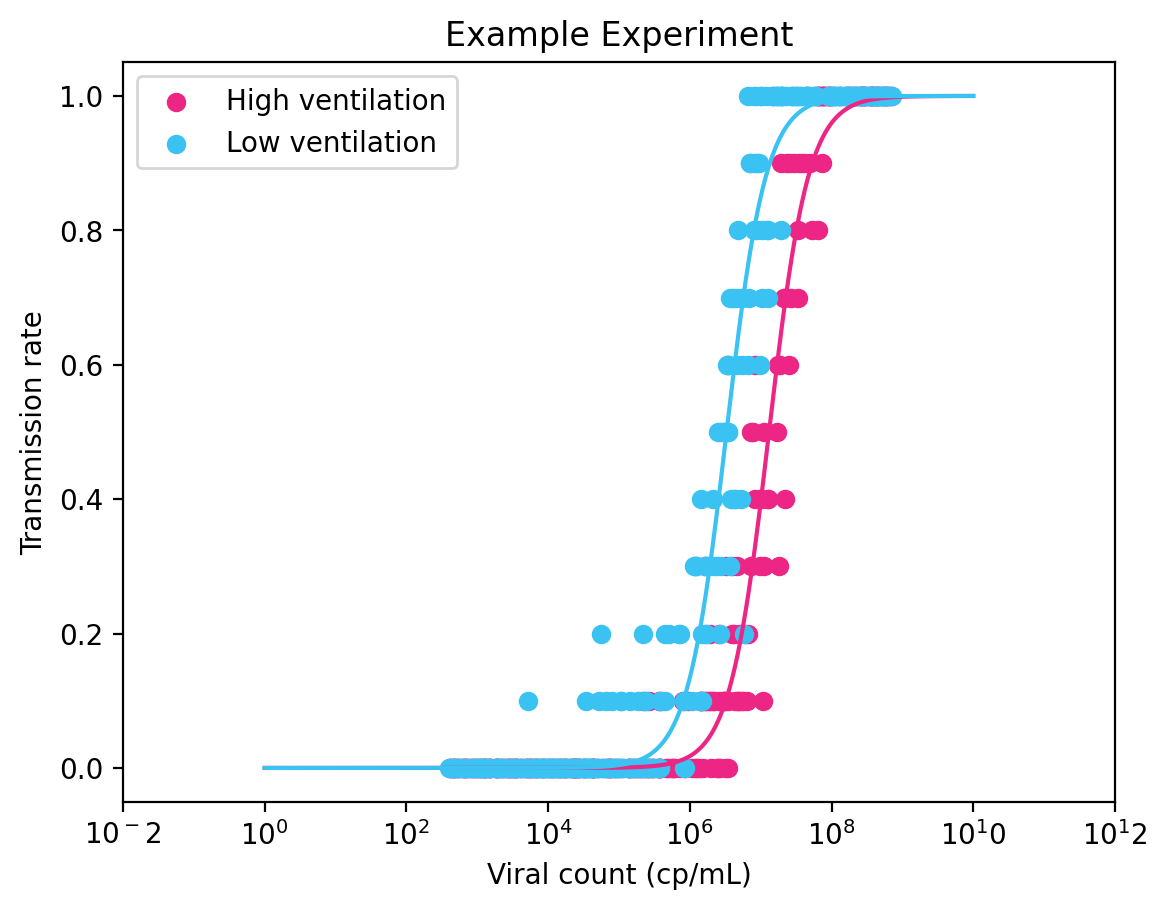

In [28]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

In [ ]:
res = run_power_analysis(
                   num_donors=40,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=400,
                   repeated_measures=False,
                   tests={'t-test', 'joint logistic'})

Powers
 {'joint logistic': 0.7325, 't-test': 0.19}


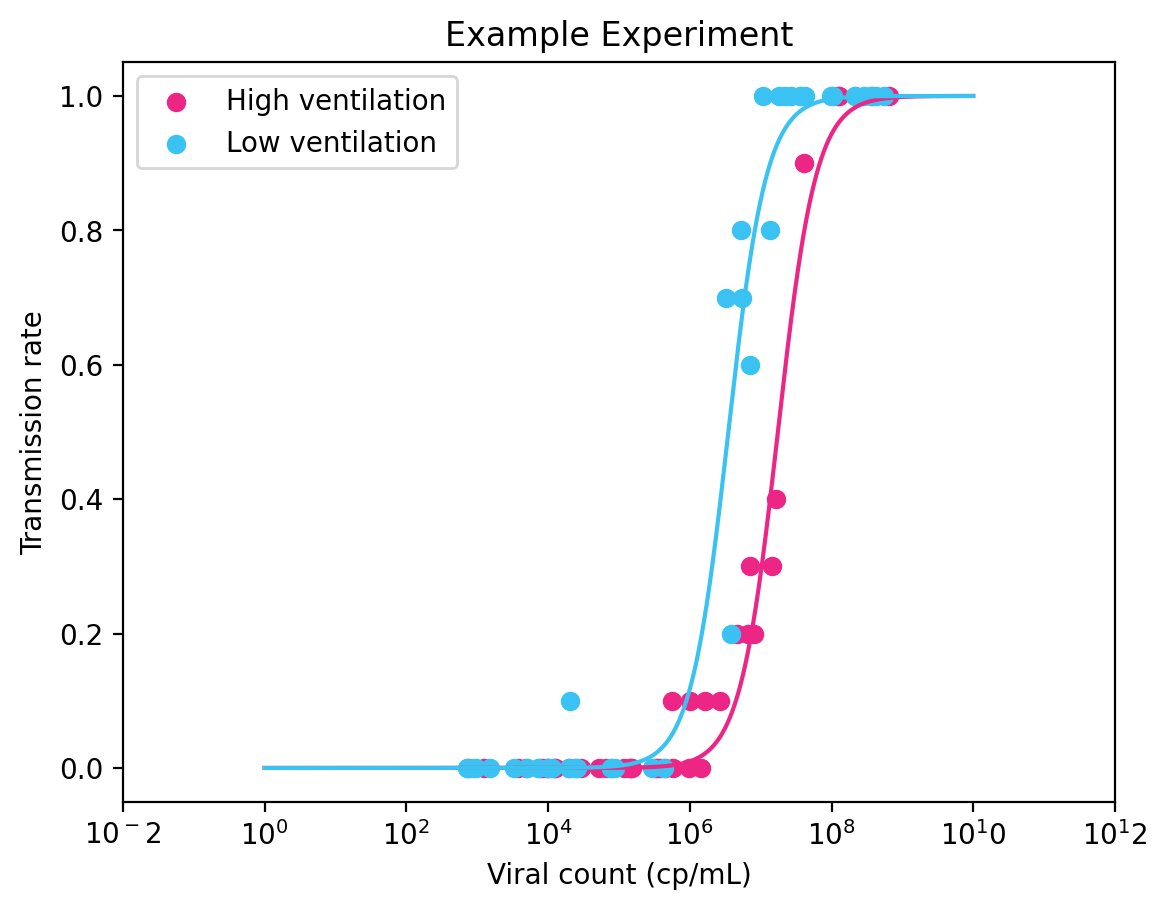

In [30]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

### Repeated measures, no variability in susceptibility

In [ ]:
res = run_power_analysis(
                   num_donors=20,
                   num_recipients_per_donor=10,
                   suscept_sd=0.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)

Powers
 {'joint logistic': 0.775, 'paired t-test': 0.705, 'wilcoxon': 0.76, 't-test': 0.0}


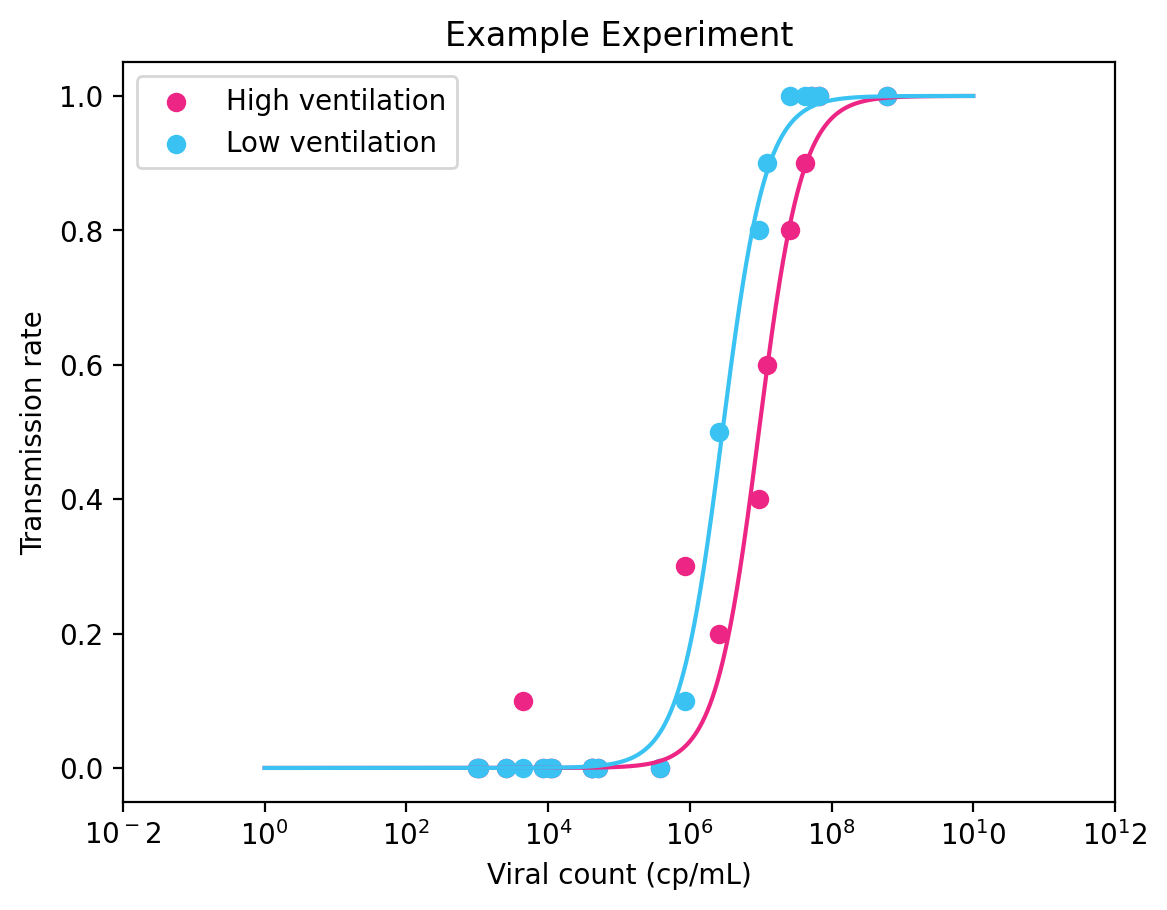

In [15]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

### Repeated measures variability in susceptibility

In [16]:
res = run_power_analysis(
                   num_donors=20,
                   num_recipients_per_donor=10,
                   suscept_sd=1.5,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)

Powers
 {'joint logistic': 0.64, 'paired t-test': 0.57, 'wilcoxon': 0.565, 't-test': 0.0}


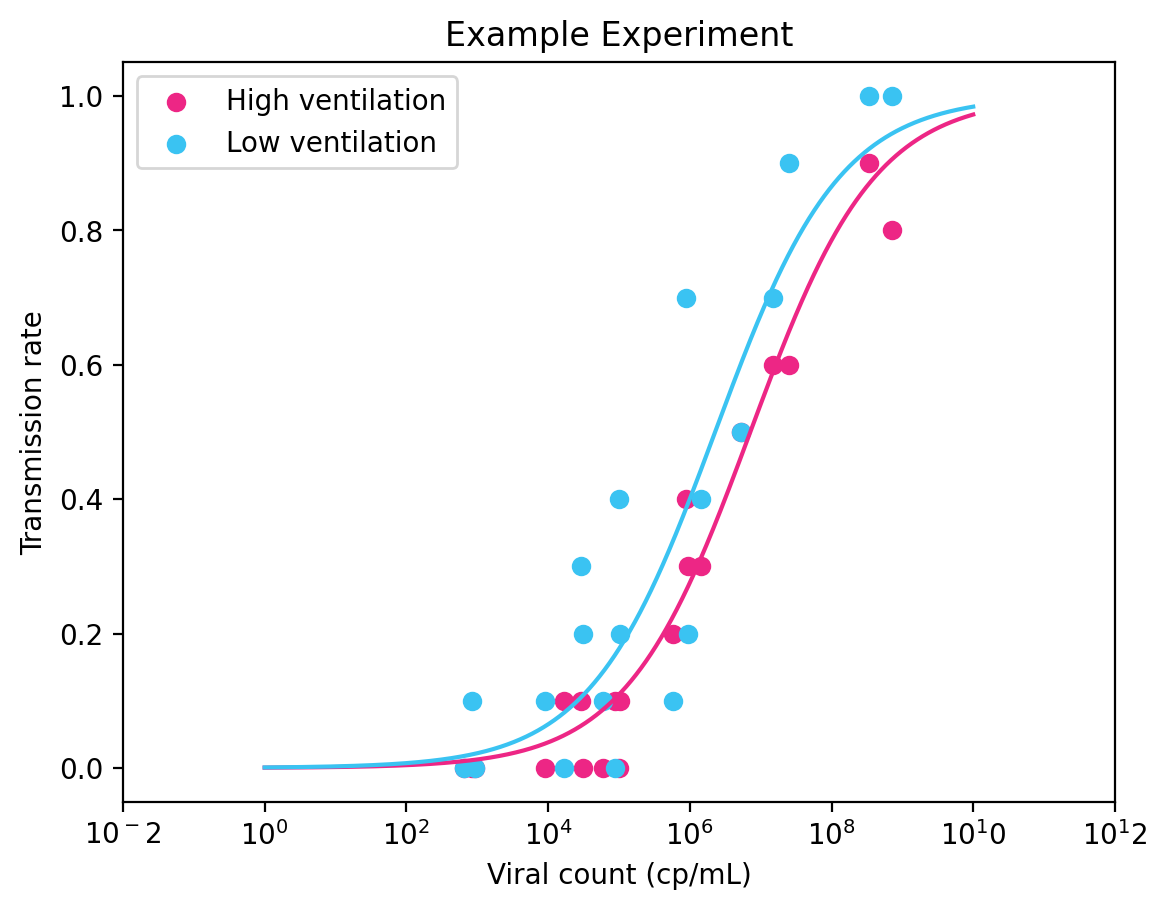

In [17]:
print('Powers\n', res['powers'])
plot_logistic(res['log_cpml_lo'], res['log_cpml_hi'], res['infection_rates_lo'], res['infection_rates_hi'], res['last_iter_logistic_params'], title='Example Experiment')

## Power curves

#### Assuming 4x differences

In [25]:
num_donors_list = [40, 20, 10, 5]
num_recipients_per_donor_list = np.arange(3, 20)
power_curves = {}
for num_donors in num_donors_list:
    power_curves[num_donors] = []
    for num_recipients_per_donor in num_recipients_per_donor_list:
        res = run_power_analysis(
                           num_donors=num_donors,
                           num_recipients_per_donor=num_recipients_per_donor,
                           suscept_sd=0.0,
                           multiplier_lo=0.5,
                           multiplier_hi=2,
                           niter=3000,
                           tests={'wilcoxon'})
        power_curves[num_donors].append(res['powers']['wilcoxon'])


Text(0.5, 1.0, 'For 4x reduction in inhaled quanta')

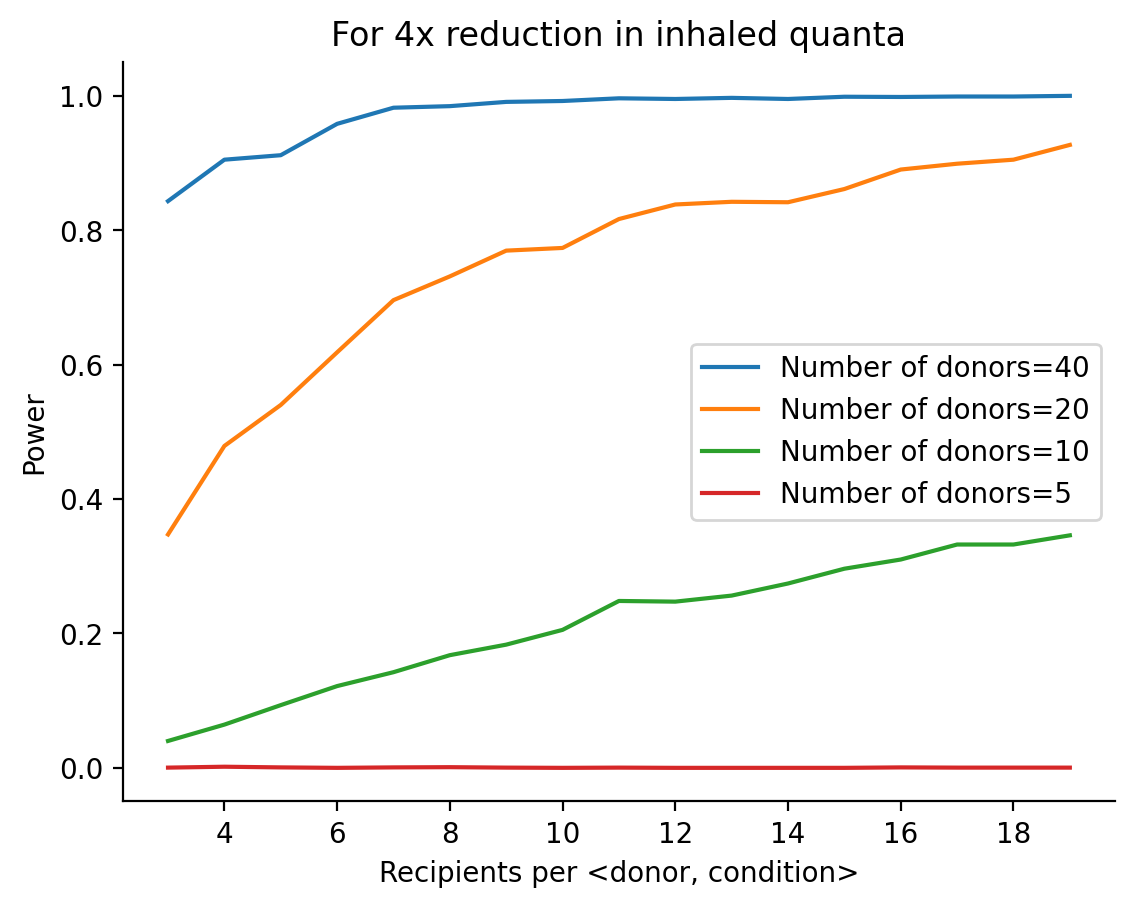

In [26]:
for num_donors in num_donors_list:
    plt.plot(num_recipients_per_donor_list, power_curves[num_donors], label=f'Number of donors={num_donors}')
plt.legend()
plt.xlabel('Recipients per <donor, condition>')
plt.ylabel('Power')
sns.despine()
plt.title('For 4x reduction in inhaled quanta')

### Assuming 10x differences

In [20]:
num_donors_list = [40, 20, 10, 5]
num_recipients_per_donor_list = np.arange(3, 20)
power_curves = {}
for num_donors in num_donors_list:
    power_curves[num_donors] = []
    for num_recipients_per_donor in num_recipients_per_donor_list:
        res = run_power_analysis(
                           num_donors=num_donors,
                           num_recipients_per_donor=num_recipients_per_donor,
                           suscept_sd=0.0,
                           multiplier_lo=1/np.sqrt(10),
                           multiplier_hi=np.sqrt(10),
                           niter=3000,
                           tests={'wilcoxon'})
        power_curves[num_donors].append(res['powers']['wilcoxon'])


Text(0.5, 1.0, 'For 10x reduction in inhaled quanta')

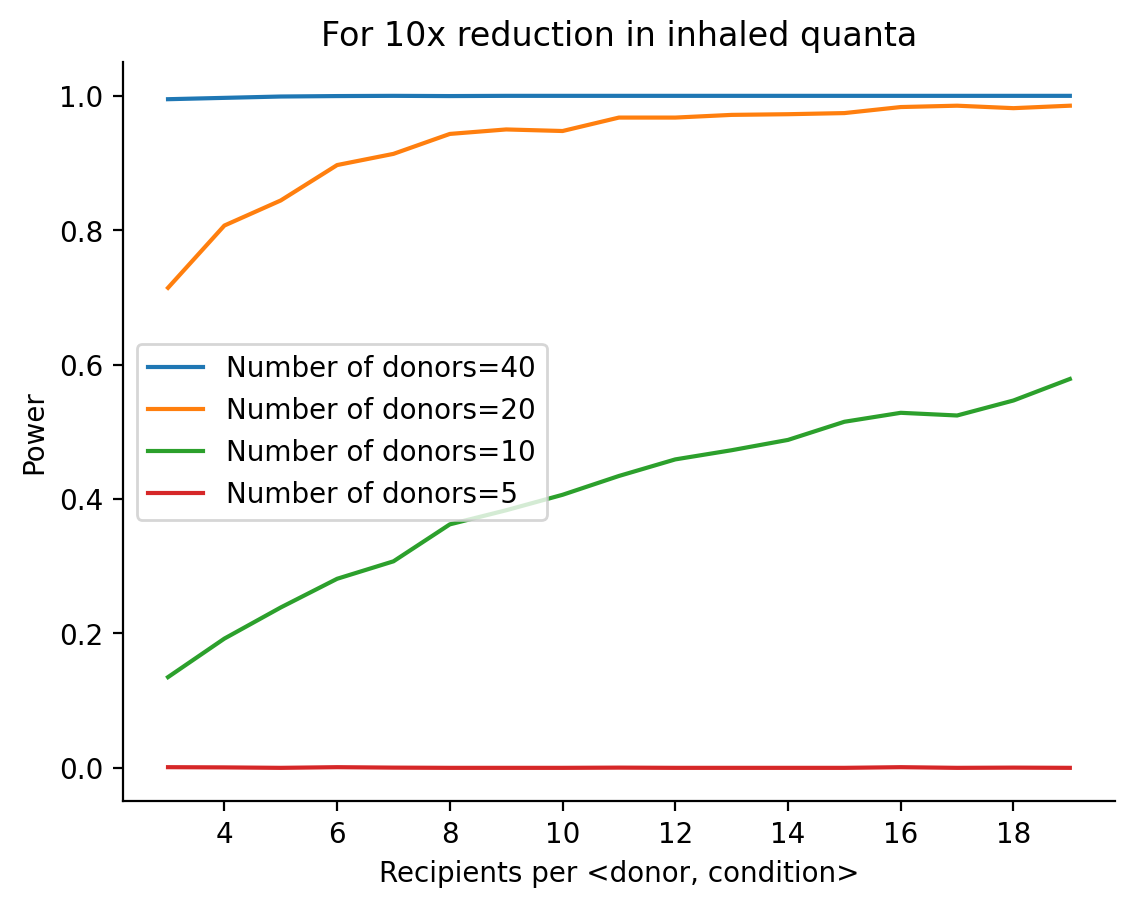

In [24]:
for num_donors in num_donors_list:
    plt.plot(num_recipients_per_donor_list, power_curves[num_donors], label=f'Number of donors={num_donors}')
plt.legend()
plt.xlabel('Recipients per <donor, condition>')
plt.ylabel('Power')
sns.despine()
plt.title('For 10x reduction in inhaled quanta')